In [1]:
from dateutil.parser import parse
#import matplotlib
#matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from matplotlib.dates import YearLocator, MonthLocator, DateFormatter



import pandas as pd
import re
import seaborn as sns
from scipy import stats
import warnings
import os

from datetime import datetime
sns.set_style('whitegrid')

warnings.filterwarnings('ignore')
%matplotlib inline

## Parse functions

In [2]:
def parse_actual_date(val):
    try:
        cur_val = val.split('on')[1][1:].split('Undergrad')[0][:-1]
        #print(cur_val)
        return parse(cur_val)
    except:
        #print(val)
        return np.nan
    
def parse_gpa(val):
    try:
        cur_val = val.split('GPA: ')[1].split('GRE')[0]
        #print(cur_val)
        return float(cur_val)
    except:
        #print(val)
        return np.nan
    
def parse_gre(val):
    try:
        cur_val = val.split('(V/Q/W): ')[1].split('GRE')[0].split('/')
        #print(cur_val)
        return cur_val
    except:
        #print(val)
        return [np.nan, np.nan, np.nan]
    
def parse_decision(val):
    try:
        cur_val = val.split('on')[0][:-1]
        #print(cur_val)
        return cur_val.lower()
    except:
        #print(val)
        return np.nan

def replace_date(val): 
    try: 
        return val.replace(year=2017)
    except:
        #print(val)
        return np.nan
    
def parse_gre_subject(val):
    try:
        cur_val = val.split('GRE Subject: ')[1][:-1]
        #print(cur_val)
        return float(cur_val)
    except:
        #print(val)
        return np.nan

## Plot functions

In [3]:
def plot_gre(tst, fig, keys_list=['accepted', 'rejected', 'interview'], 
            colors = ['green', 'red', 'orange'],
            title='GRE distributions',
            subplot_loc=312):
    
    color_dict = dict(zip(keys_list, colors))
    gre_df = tst.loc[~tst[['gre_q', 'gre_v', 'gre_awa']].isnull().any(axis=1)]
    #all_size = gre_df.shape[0]
    #print(gre_df.shape)
    
    gre_df[['gre_q', 'gre_v']] = gre_df[['gre_q', 'gre_v']].astype(float)

    #fig = plt.figure()
    ax = fig.add_subplot(subplot_loc)
    #fig = plt.figure()
    all_dfs = []
    label_list = []
    for score_type in ['gre_q', 'gre_v']: 
        #gre_df = all_gre_df[~all_gre_df[score_type].isnull()]
        for item in keys_list:
            cur_df = gre_df.loc[gre_df.decision_parsed.str.lower().str.contains(item)]
            
            cur_df['Score'] = cur_df[score_type].astype(float)
            cur_df['Score type'] = score_type.upper()
            label_list += [item + ' (N={:d})'.format(len(cur_df))]
            cur_df['Status'] = label_list[-1] 
            if len(cur_df) >= 5:
                all_dfs += [cur_df[['Score', 'Score type', 'Status']]]
    
    color_dict = dict(zip(label_list, colors))
    sns.boxplot(x='Score type', y='Score', hue='Status', data = pd.concat(all_dfs, axis=0), 
                palette=color_dict, width=0.6)
    plt.legend(frameon=True, loc=3)
    #fig.set_size_inches((5,5))
    plt.title(title)

def plot_gpa(tst, fig, keys_list=['accepted', 'rejected', 'interview', 'wait'], 
        colors = ['green', 'red', 'orange', 'blue'],
        title='GPA distribution (median ± std, N)',
        subplot_loc=313):

    gpa_df = tst[~tst.gpa.isnull()]
    #print(gpa_df.shape)

    color_dict = dict(zip(keys_list, colors))

    gpa_df.gpa = gpa_df.gpa.astype(float)
    gpa_df = gpa_df[gpa_df.gpa <= 4.0]
    gpa_df = gpa_df[gpa_df.gpa >= 2.5]
    #fig = plt.figure()
    #fig = plt.figure()
    ax = fig.add_subplot(subplot_loc)

    for item in keys_list[:-1]:
        cur_df = gpa_df[gpa_df.decision_parsed.str.lower().str.contains(item)]
        median_gpa = ' ({:.2f} '.format(cur_df.gpa.median())
        std_gpa = '± {:.2f}, '.format(cur_df.gpa.std())
        observations = 'N={:d})'.format(cur_df.shape[0])
        if cur_df.shape[0] >= 5:
            plt.hist(cur_df.gpa, bins=np.linspace(2.5, 4.0, 16), label=item + median_gpa + std_gpa + observations  , \
                     color=color_dict[item], alpha=0.7)
    plt.legend()
    plt.xlabel('GPA bins (from 2.5 to 4.0 with 0.1 step)')
    plt.ylabel('GPA counts')
    #fig.set_size_inches(5, 5)
    plt.title(title)
    #return fig, ax
    
def plot_timelines(tst, fig, keys_list=['accepted', 'rejected', 'interview', 'wait'], 
            colors = ['green', 'red', 'orange', 'blue'],
            title='Decision timelines',
            subplot_loc=311):

    years = YearLocator()   # every year
    months = MonthLocator()  # every month
    yearsFmt = DateFormatter('%B')
    color_dict = dict(zip(keys_list, colors))
    #plot_df = tst.groupby(by='actual_date').size()
    #fig = plt.figure()
    ax = fig.add_subplot(subplot_loc)
    #canvas = FigureCanvas(fig)


    for item in keys_list:
        cur_df = tst[tst.decision_parsed.str.lower().str.contains(item)]
        cur_size = cur_df.shape[0]
        observations = ' (N={:d})'.format(cur_size)

        cur_df = cur_df.groupby(by='actual_date').size()
        #print(cur_df)
        cur_df = cur_df.sort_index()
        cur_df = cur_df.cumsum()
        #kernel = stats.gaussian_kde(cur_df.values)
        if cur_size > 5:

            plt.plot_date(y = cur_df.values, x = cur_df.index, fmt='-', label=item + observations, color=color_dict[item], alpha=0.8)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.tick_params(direction='out', length=6, width=1)

    ax.autoscale_view()
    #fig.autofmt_xdate()
    plt.legend()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Cumsum of decisions')
    #plt.show()
    #fig.set_size_inches(5, 5)
    #fig.set_dpi(50)
    #canvas.draw()       # draw the canvas, cache the renderer
    #width, height = fig.get_size_inches() * fig.get_dpi()
    #print(width,height, fig.get_dpi())
    #image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)

    #return image
    
def plot_all_data(data, uni_query='(?=.*georgia)(?=.*tech)|gatech', program_query='computer | electrical e | eecs',
                  degree_query = 'phd | master', suptitle='Test title',filter_questions=True, 
                  savepath='../graphs/test.png', data_threshold=50, savefig=True):

    tst = data[data.actual_date.dt.year < 2018].copy()
    print('Initial shape', tst.shape)
    tst = tst[tst.actual_date.dt.year > 2012]
    tst = tst[(tst.uni.str.lower().str.contains(uni_query)) \
               & (tst.program.str.lower().str.contains(program_query))]
    tst = tst[tst.program.str.lower().str.contains(degree_query)]
    tst.actual_date = tst.actual_date.apply(replace_date)
    tst.loc[tst.gre_q.astype(float) > 170, 'gre_q'] = np.nan
    tst.loc[tst.gre_q.astype(float) < 140, 'gre_q'] = np.nan
    tst.loc[tst.gre_v.astype(float) > 170, 'gre_v'] = np.nan
    tst.loc[tst.gre_v.astype(float) < 140, 'gre_v'] = np.nan

    tst = tst[tst.actual_date.notnull()]
    start_date = pd.to_datetime('2017-1-1')
    end_date = pd.to_datetime('2017-5-1')
    tst = tst[tst.actual_date <= end_date]
    tst = tst[tst.actual_date >= start_date]
    print('Shape after cleaning data', tst.shape)
    
    if tst.shape[0] >= data_threshold:
        if filter_questions:
            tst = tst[~tst.comment.str.lower().str.contains('poster|below').fillna(False)]
            tst = tst[~tst.comment.str.lower().str.contains('anyone|anybody').fillna(False)]
            tst = tst[~tst.comment.str.lower().str.contains('(?=.*who)(?=.*knows)(?=.*\?)').fillna(False)]



            print('Shape after filtering questions', tst.shape)

        fig = plt.figure(figsize=(15,5),dpi=150)
        plot_timelines(tst, fig, subplot_loc=131)
        plot_gre(tst, fig, subplot_loc=132)
        plot_gpa(tst, fig, subplot_loc=133)
        plt.suptitle(suptitle, fontsize=22, y=1.0)
        if savefig:
            plt.savefig(savepath, transparent=False)
        #plt.show()
    else:
        print("Data didn't pass {} element threshold".format(data_threshold) )
    return tst

## Reading and parsing data

In [4]:
data = pd.read_csv('../data/gradcafe_data_parsed.csv', usecols=range(1,7) )
data['date'] = pd.to_datetime(data.date)
data['actual_date'] = data.decision.apply(parse_actual_date)
data.actual_date = pd.to_datetime(data.actual_date, errors='coerce')
data['gpa'] = data.decision.apply(parse_gpa)
#data['gre_subject'] = data.decision.apply(parse_gre_subject)
gre_df = pd.DataFrame(list(data.decision.apply(parse_gre)), columns = ['gre_v', 'gre_q', 'gre_awa'], index=data.index)
data = pd.concat([data, gre_df], axis=1)
data['decision_parsed'] = data.decision.apply(parse_decision)

## Defining regular expressions for universities

In [5]:
uni_list = [('All Universities', ''),
 ('Carnegie Mellon University', 'carnegie | mellon | cmu'),
 ('Stanford University', 'stanford'),
 ('Yale University', 'yale'),
 ('Cornell University', 'cornell'),
 ('Georgia Institute of Technology', '(?=.*georgia)(?=.*tech)|gatech'),
 ('University of California — Berkeley', 'berk'),
 ('University of Washington — Seattle', '((?=.*wash)(?=.*seattle))|((?=.*uw)(?=.*seattle))|((?=.*uni)(?=.*wash)^(?!.*loui)^(?!.*uwash)^(?!.*georg)^(?!.*stat))'),
 ('Massachusetts Institute of Technology', '(?=.*mit)^((?!rmit).)'),
 ('University of Massachusetts Amherst', 'amherst'),
 ('University of Michigan', '(?=.*mich)(?=.*sity of)|umich'),
 ('University of Texas at Austin', 'austin'),
 ('University of Pennsylvania', '((?=.*penns)(?=.*univ)(?=.*of))|upenn'),
 ('University of Southern California', '((?=.*univ)(?=.*south)(?=.*cal))'),
 ('Univ. of Illinois at Urbana-Champaign', '((?=.*illin)(?=.*champ)(?=.*urb))'),
 ('University of Maryland — College Park', '((?=.*maryland)(?=.*ark))'),
 ('University of California — Los Angeles', '((?=.*ucla))|((?=.*uni)(?=.*cali)(?=.*los)(?=.*angel))'),
 ('Columbia University', '((?=.*columbia)^(?!.*british)^(?!.*misso)^(?!.*northw)^(?!.*umc))'),
 ('Northeastern University', '((?=.*northeaster))|neu'),
 ('Harvard University', '((?=.*harvard))'),
 ('Purdue University', '((?=.*purdue)^(?!.*indi)^(?!.*iupui))'),
 ('Arizona State University', '((?=.*ariz)(?=.*stat))'),
 ('New York University', '((?=.*new)(?=.*yor)(?=.*uni)^(?!.*buff)^(?!.*brook)^(?!.*alb)^(?!.*city)^(?!.*osw)^(?!.*columb))|nyu'),
 ('University of California — San Diego', '((?=.*ucsd))|((?=.*uni)(?=.*cali)(?=.*san)(?=.*die))'),
 ('University of Illinois at Chicago', '((?=.*illin)(?=.*chic))'),
 ('University of Texas at Dallas', '((?=.*tex)(?=.*dalla))|((?=.*ut)(?=.*dalla))|utd'),
 ('Oregon State University', '((?=.*oregon)(?=.*state))'),
 ('University of Wisconsin — Madison', '((?=.*wisc)(?=.*mad))|((?=.*madison))'),
 ('Stony Brook University', '((?=.*stony)(?=.*brook))'),
 ('Johns Hopkins University', '((?=.*joh)(?=.*hopk))|jhu'),
 ('University of California — Irvine', 'irvine'),
 ('University of North Carolina', '((?=.*chape))|((?=.*of)(?=.*north)(?=.*carol)^(?!.*stat))'),
 ('University of Central Florida', '((?=.*ucf))|((?=.*of)(?=.*centr)(?=.*flor))'),
 ('University of California — Davis', 'davis'),
 ('University of Virginia', '((?=.*uni)(?=.*of)(?=.*virgi))'),
 ('Michigan State University', '((?=.*michi)(?=.*state))'),
 ('Pennsylvania State University', '((?=.*penn)(?=.*state))'),
 ('Princeton University', 'princeton'),
 ('Washington University in St. Louis', '(?=.*washington)(?=.*lou)|wustl|wusl|washu'),
 ('University of California — Santa Barbara', '((?=.*ucsb))|((?=.*uni)(?=.*cali)(?=.*san)(?=.*barb))'),
 ('University of Colorado Boulder', '((?=.*bould))'),
 ('University of Utah', '((?=.*of)(?=.*utah)(?=.*uni))'),
 ('University of Minnesota', '((?=.*of)(?=.*minnes)(?=.*uni))'),
 ('Brown University', '((?=.*brown)(?=.*uni))'),
 ('Rensselaer Polytechnic Institute', '((?=.*rens)(?=.*poly))'),
 ('University of California — Santa Cruz', '((?=.*ucsc))|((?=.*uni)(?=.*cali)(?=.*cruz))'),
 ('Duke University', 'duke'),
 ('Ohio State University', '((?=.*ohio)(?=.*sta))'),
 ('Northwestern University', '((?=.*northwester))|nwu'),
 ('Rice University', '((?=.*rice)(?=.*uni))'),
 ('Texas AM University', '((?=.*tex)(?=.*uni)(?=.*a\&m))|tamu|a \& m'),
 ('Virginia Tech', '((?=.*tech)(?=.*virg))|vtech'),
 ('University of Toronto', '((?=.*uni)(?=.*of)(?=.*toron))'),
 ('University of British Columbia', '((?=.*uni)(?=.*of)(?=.*britis)(?=.*columb))|ubc'),
 ('McGill University', 'mcgill')]

## Defining regular expressions for programs

In [17]:
program_list = [('Computer Science', '((?=.*compu)(?=.*sci))'),
                ('Electrical Engineering', '((?=.*electr)(?=.*engin))'),
                ('ML, AI, CV and DS', '((?=.*machi)(?=.*learn))|((?=.*dat)(?=.*sci))|((?=.*arti)(?=.*inte))|((?=.*comp)(?=.*visio))'),
                ('Mathematics (applied and pure)', '(?=.*mathematics)'),
                ('Physics (applied and pure)', '(?=.*physics)^(?!.*bio)^(?!.*geo)'),
                ('Chemistry', '(?=.*chemist)^(?!.*bio)^(?!.*geo)'),
                ('Chemical Engineering', '(?=.*chem)(?=.*engi)'),
                ('Literature', '(?=.*litera)'),
                ('Antropology', '(?=.*anthrop)'),
                ('Bioengineering', '((?=.*bioeng))|((?=.*bio eng))|((?=.*bio)(?=.*eng))'),
                ('Statistics', '((?=.*statistic))|((?=.*stats))'),
                ('Economics', 'econom'),
                ('Philosophy', 'philosophy'),
                ('Biology', 'biology'),
                ('Civil Engineering', '((?=.*civil)(?=.*eng))'),
                ('Social work and welfare','((?=.*social)(?=.*work))|((?=.*social)(?=.*welf))')]

degree_list = [('PhD and MS', 'phd|master'),
                ('PhD', 'phd'),
                ('MS', 'master'),
                
                ]

degree_thres = {'PhD and MS':50, 'PhD': 30, 'MS':30 }

In [18]:
program_list[-1:]

[('Social work and welfare',
  '((?=.*social)(?=.*work))|((?=.*social)(?=.*welf))')]

social_work_and_welfare
All Universities, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (333, 12)
Shape after filtering questions (319, 12)
Carnegie Mellon University, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Stanford University, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Yale University, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Cornell University, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Georgia Institute of Technology, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
University of California — Berkeley, Social work and 

Shape after cleaning data (1, 12)
Data didn't pass 30 element threshold
University of British Columbia, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
McGill University, Social work and welfare, PhD 

Initial shape (466229, 12)
Shape after cleaning data (2, 12)
Data didn't pass 30 element threshold
All Universities, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (1703, 12)
Shape after filtering questions (1659, 12)
Carnegie Mellon University, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Stanford University, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Yale University, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Cornell U

Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Rice University, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Texas AM University, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
Virginia Tech, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (0, 12)
Data didn't pass 30 element threshold
University of Toronto, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (129, 12)
Shape after filtering questions (126, 12)
No objects to concatenate
University of British Columbia, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (2, 12)
Data didn't pass 30 element threshold
McGill University, Social work and welfare, MS 

Initial shape (466229, 12)
Shape after cleaning data (23, 12)
Data didn't pass 30 element thre

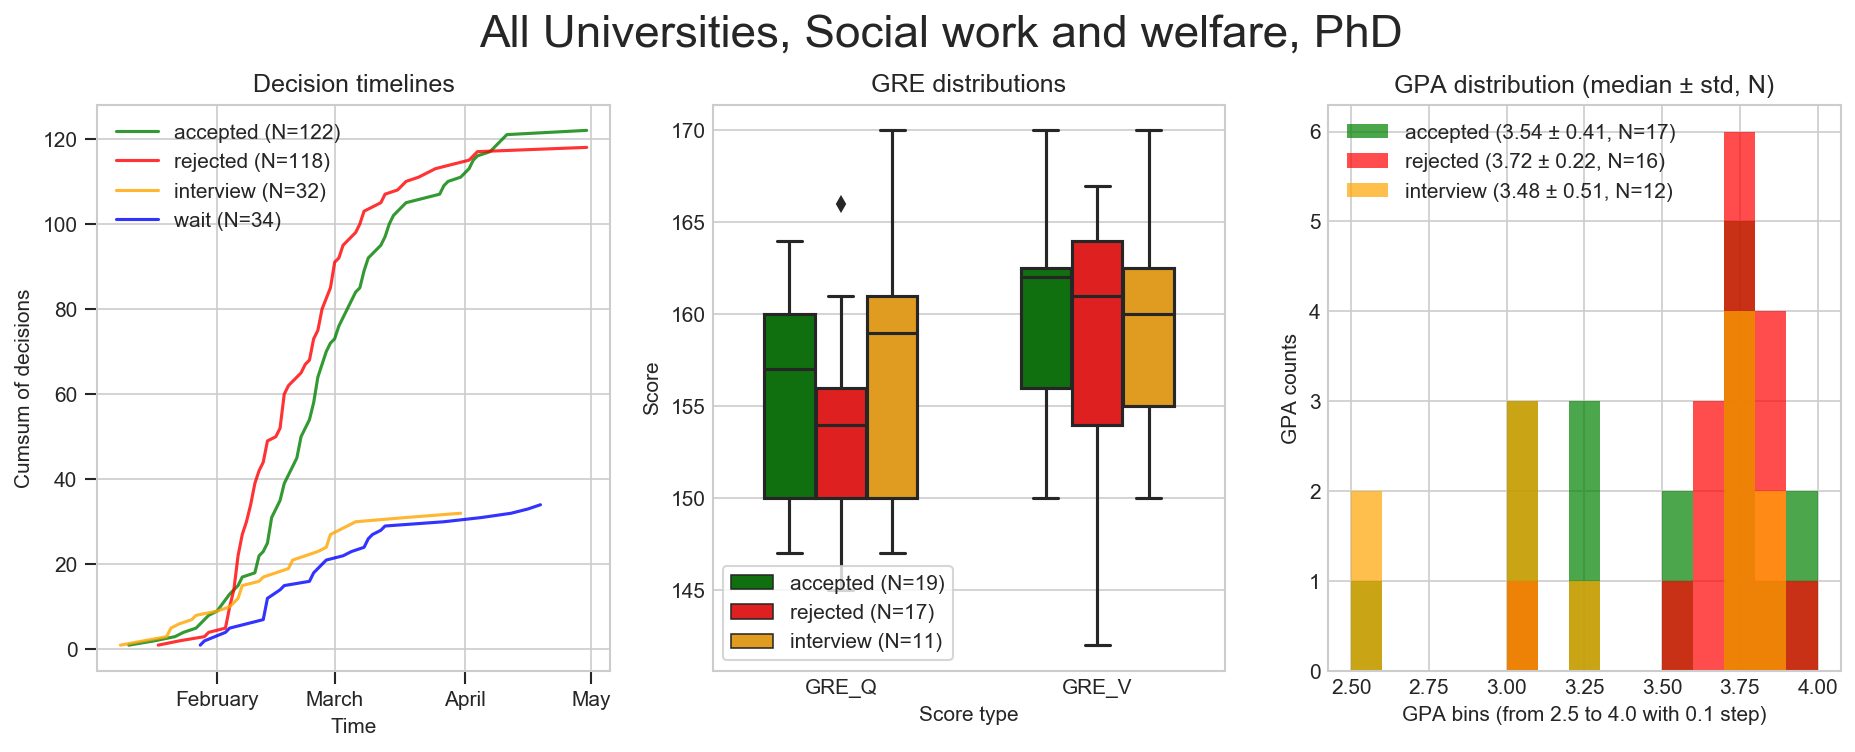

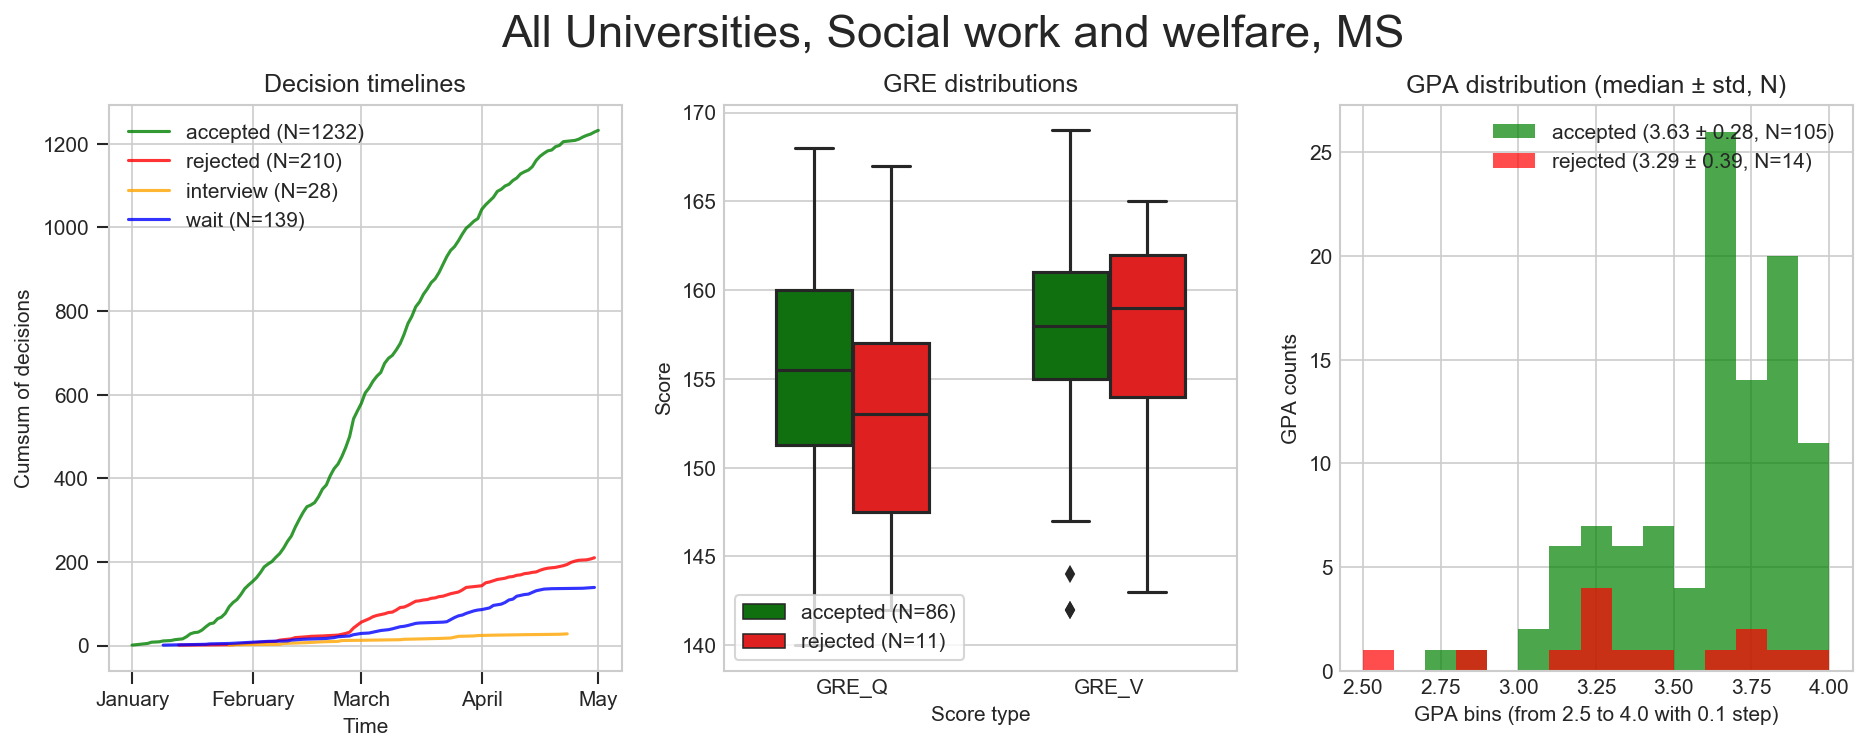

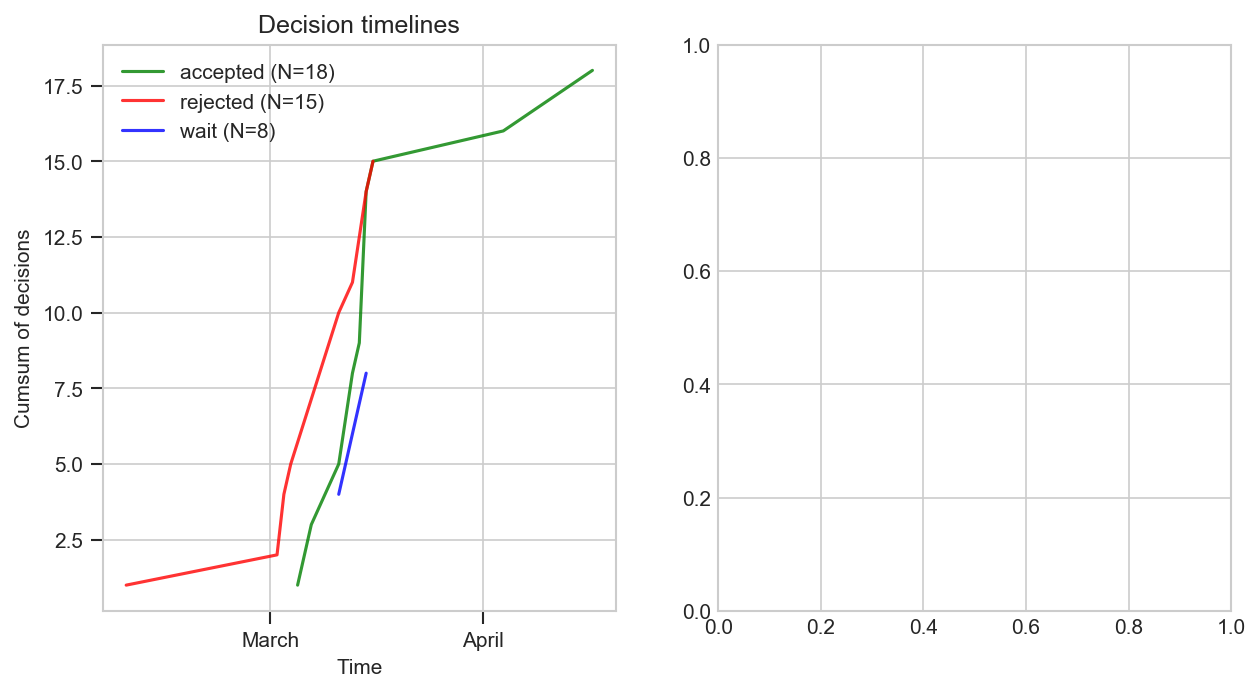

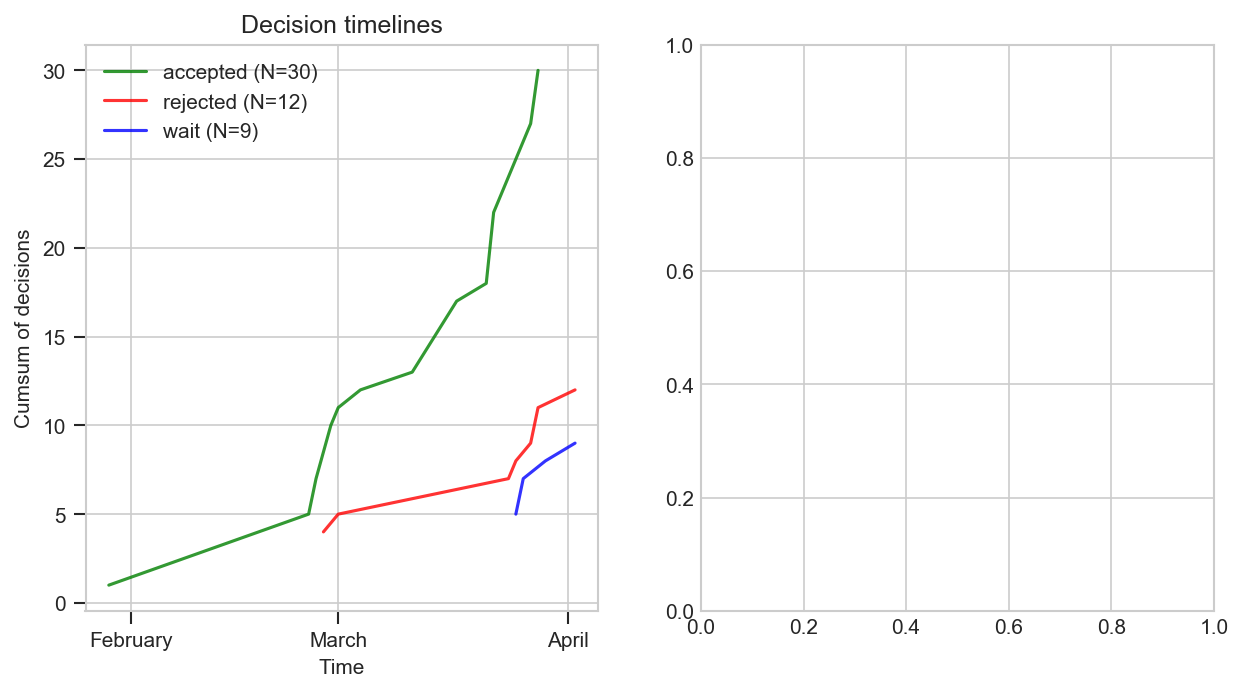

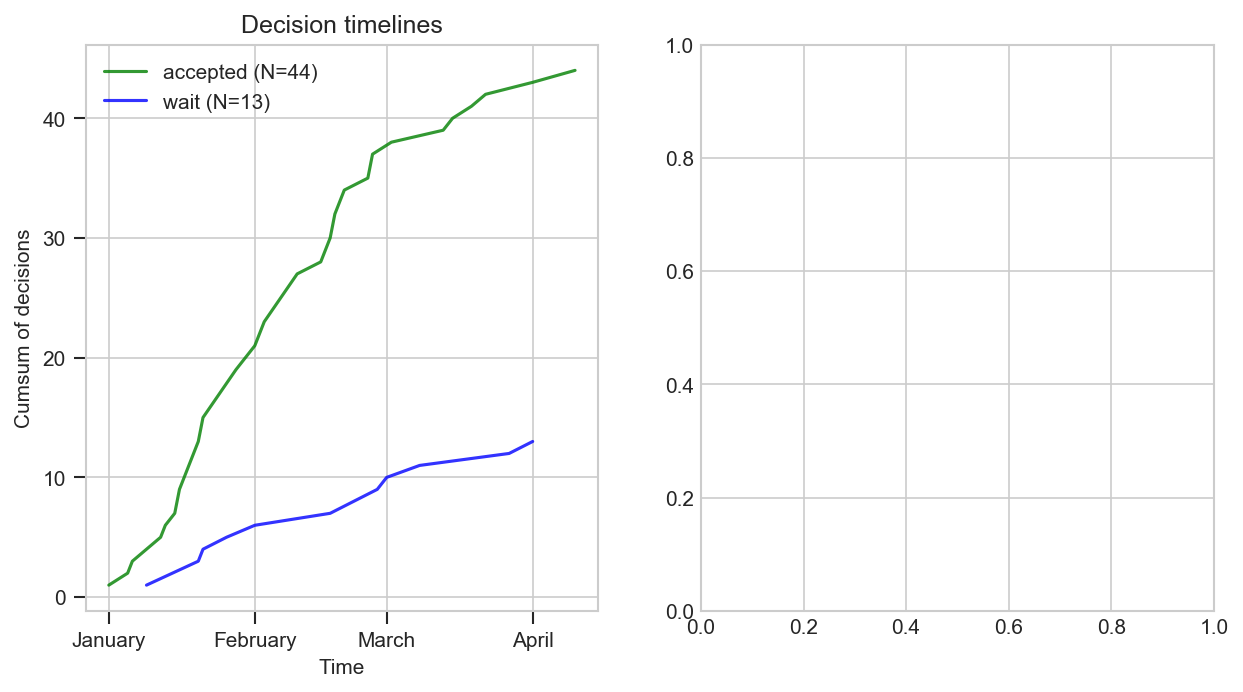

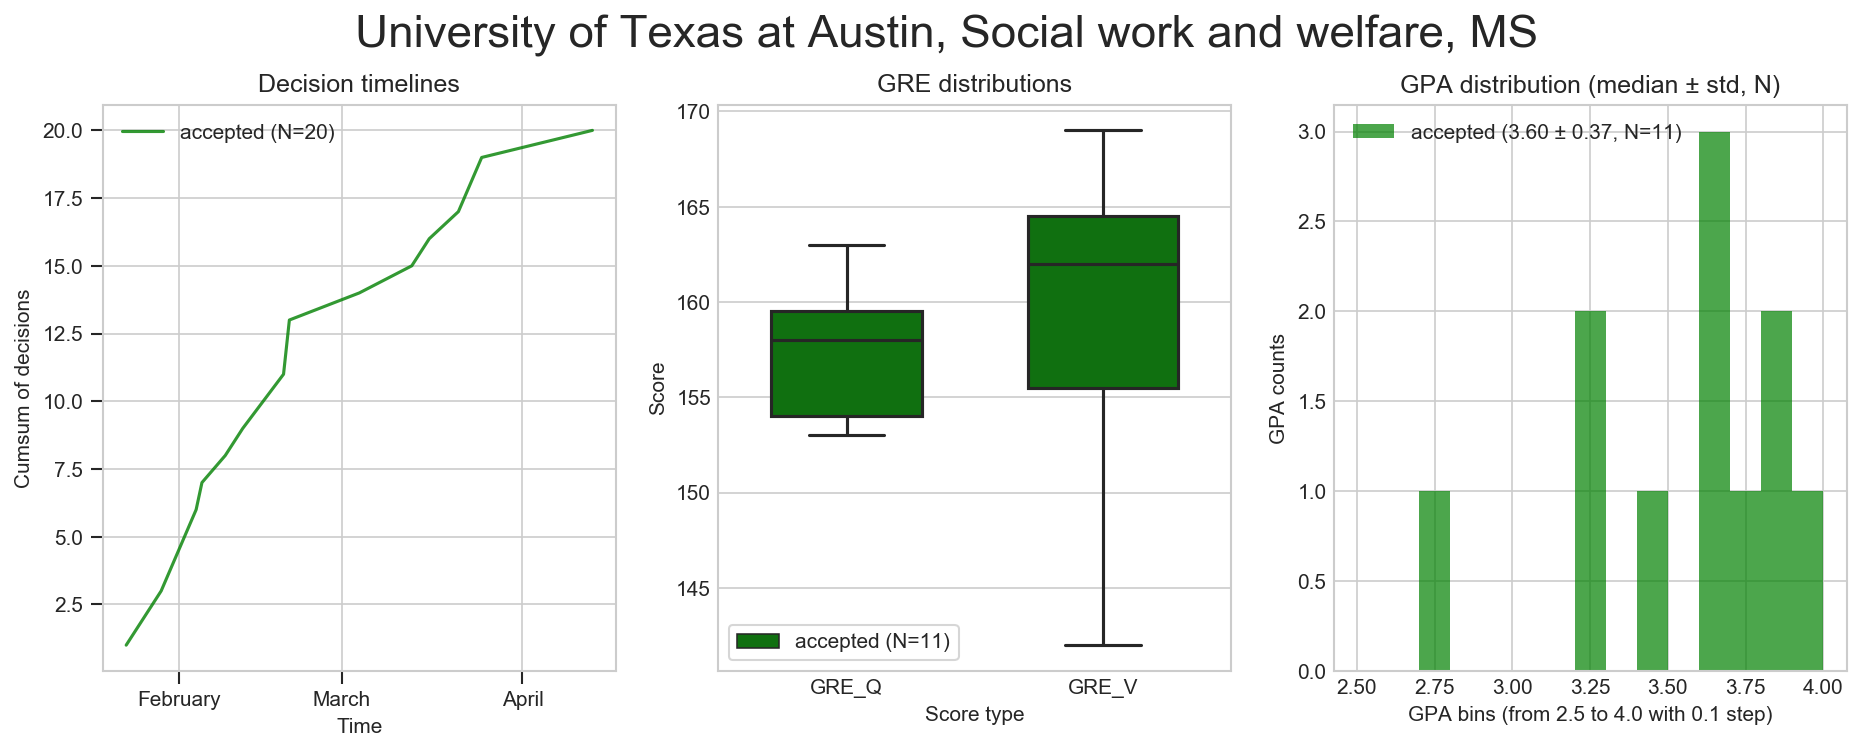

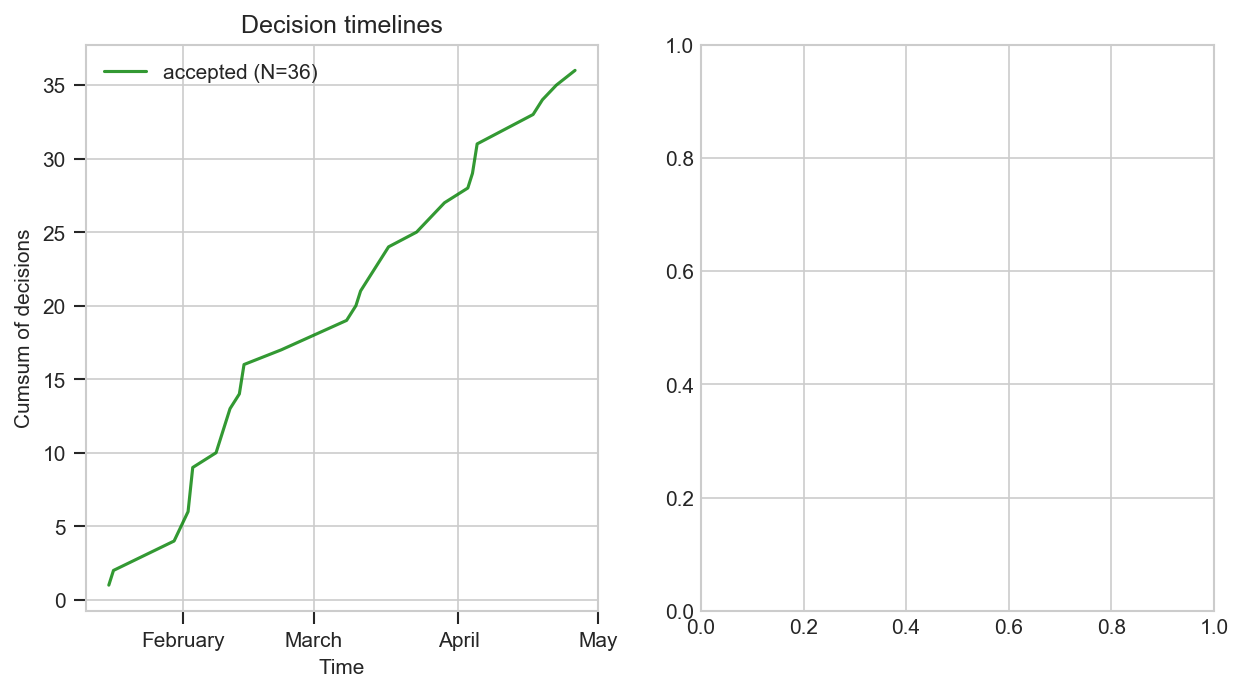

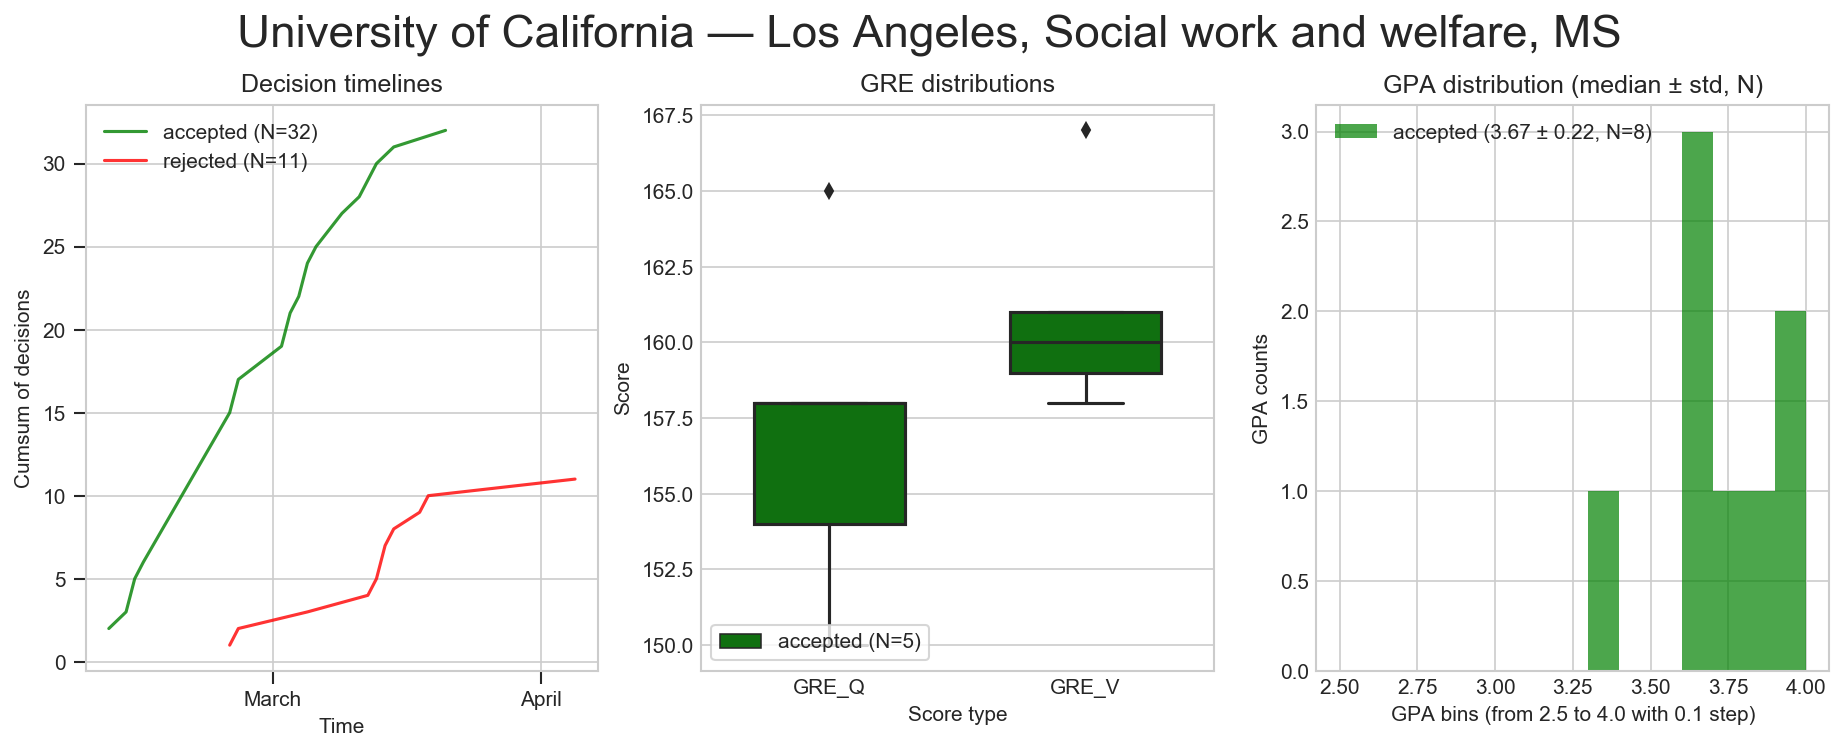

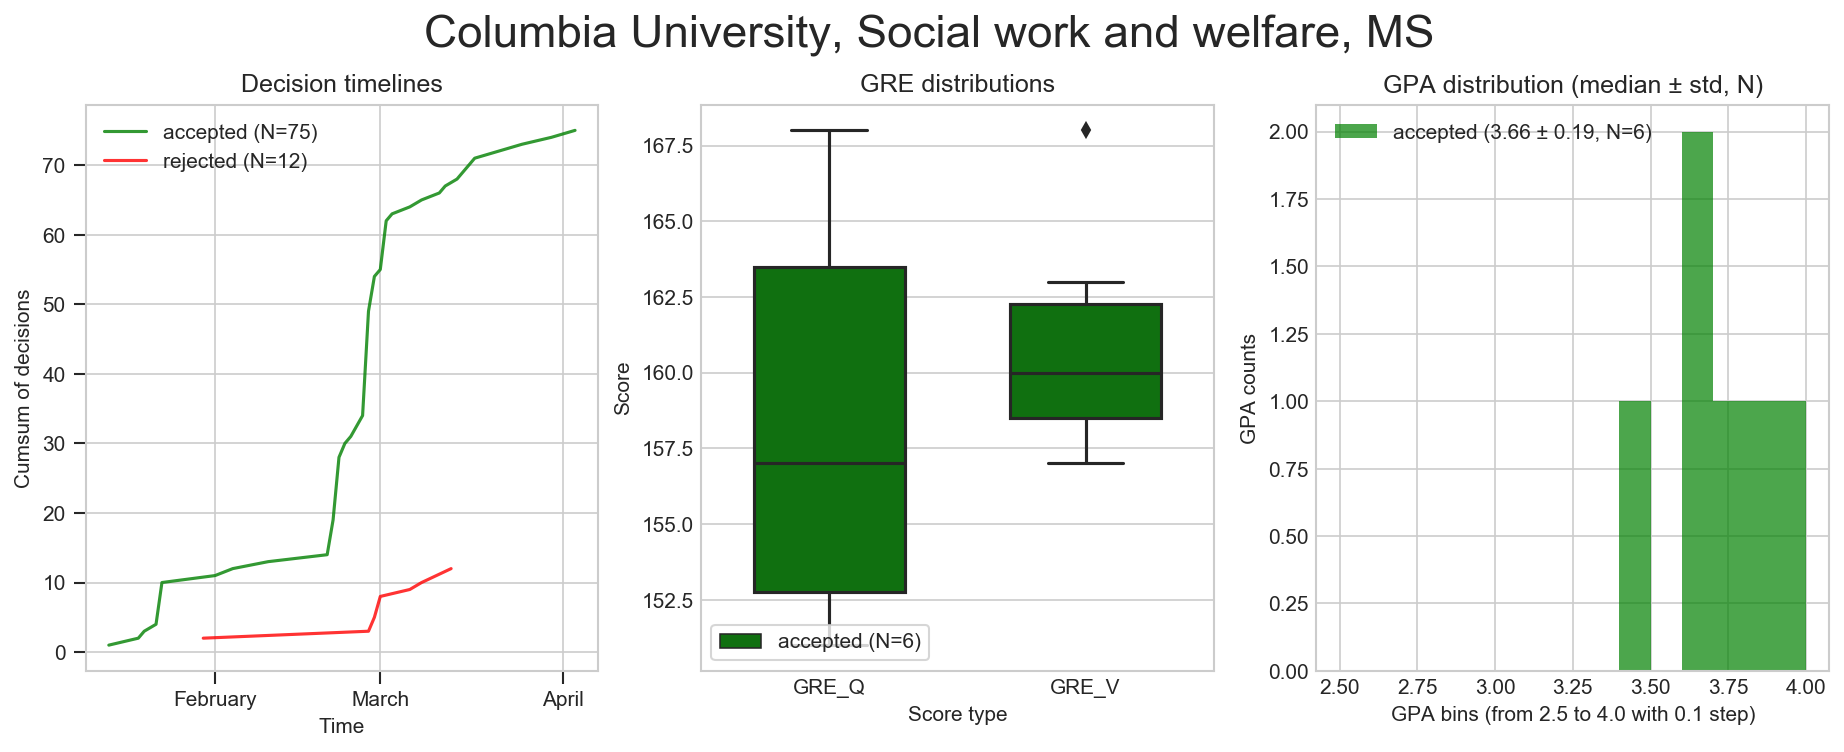

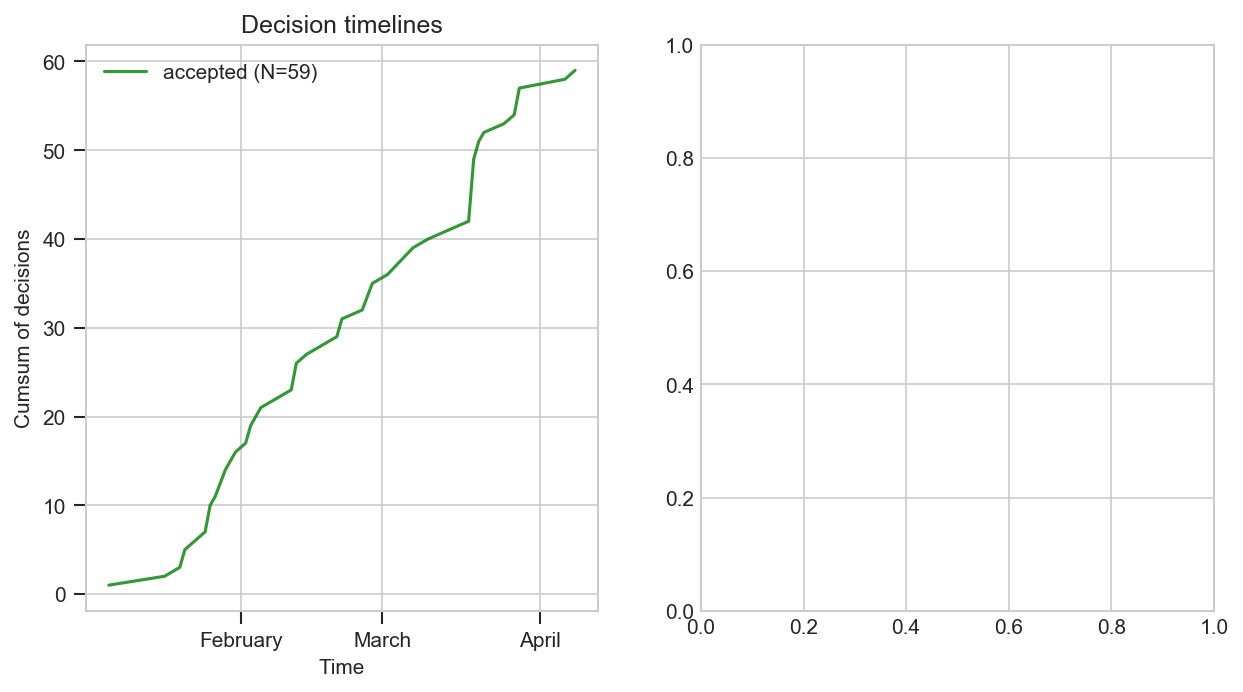

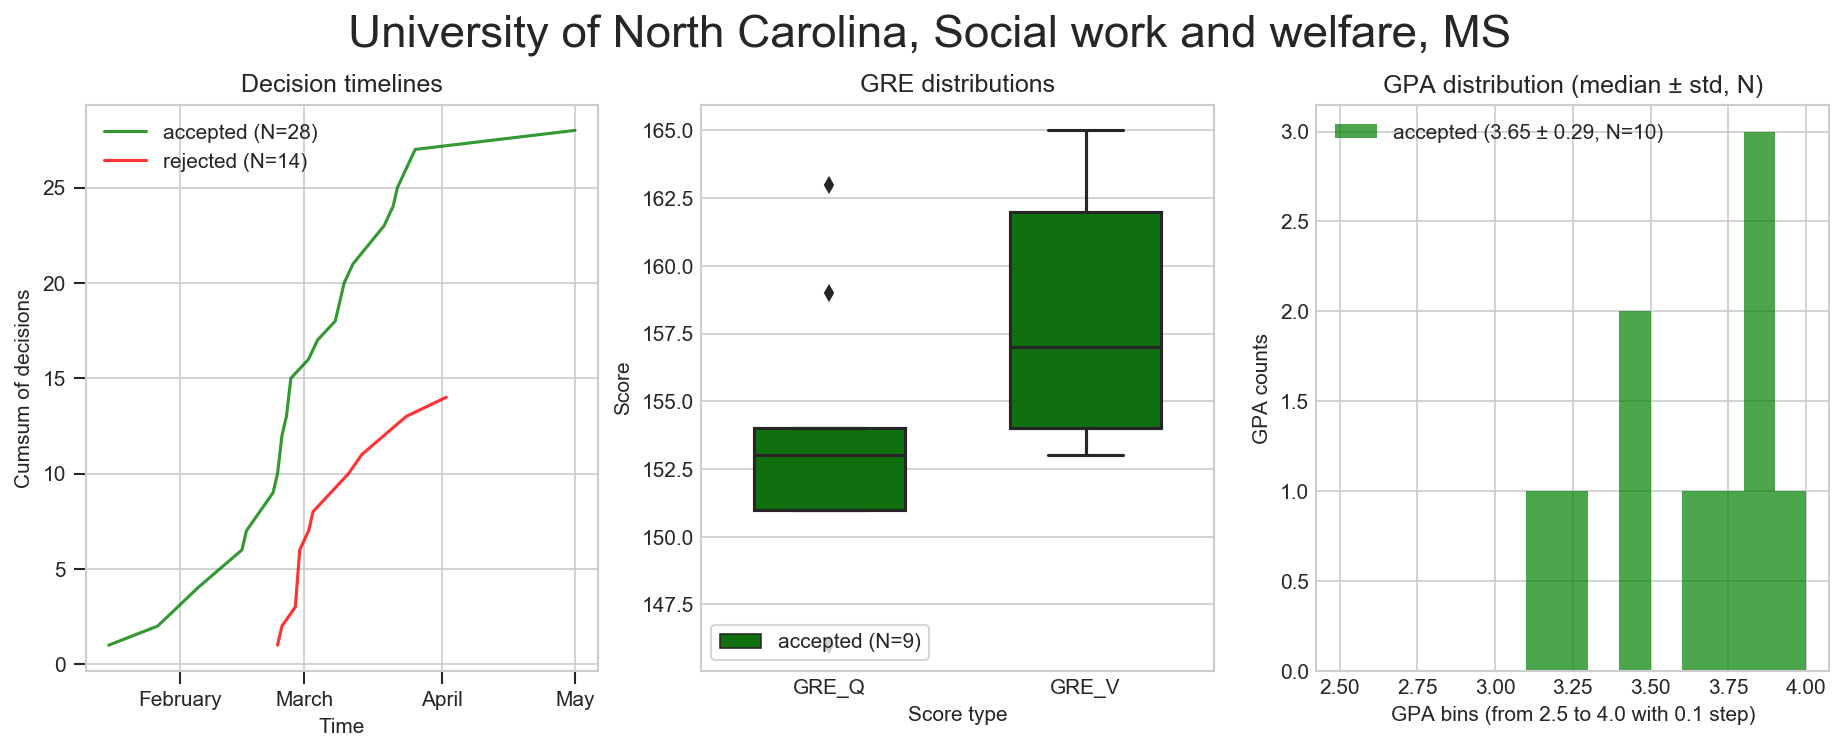

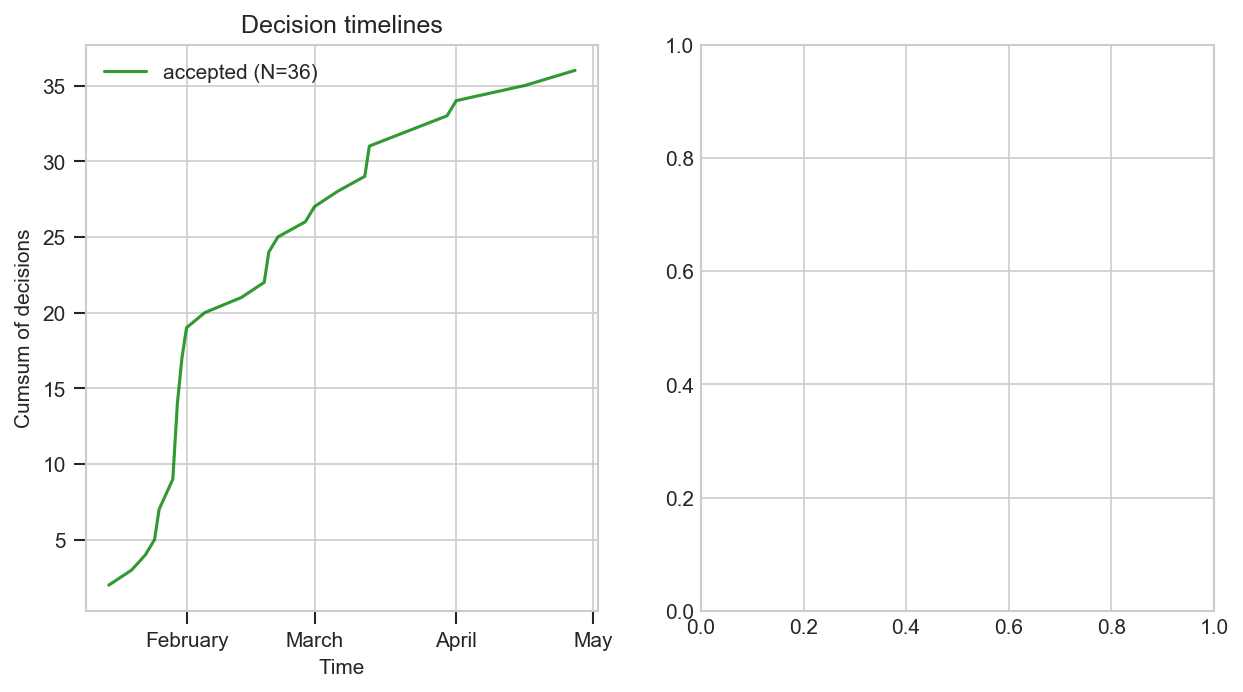

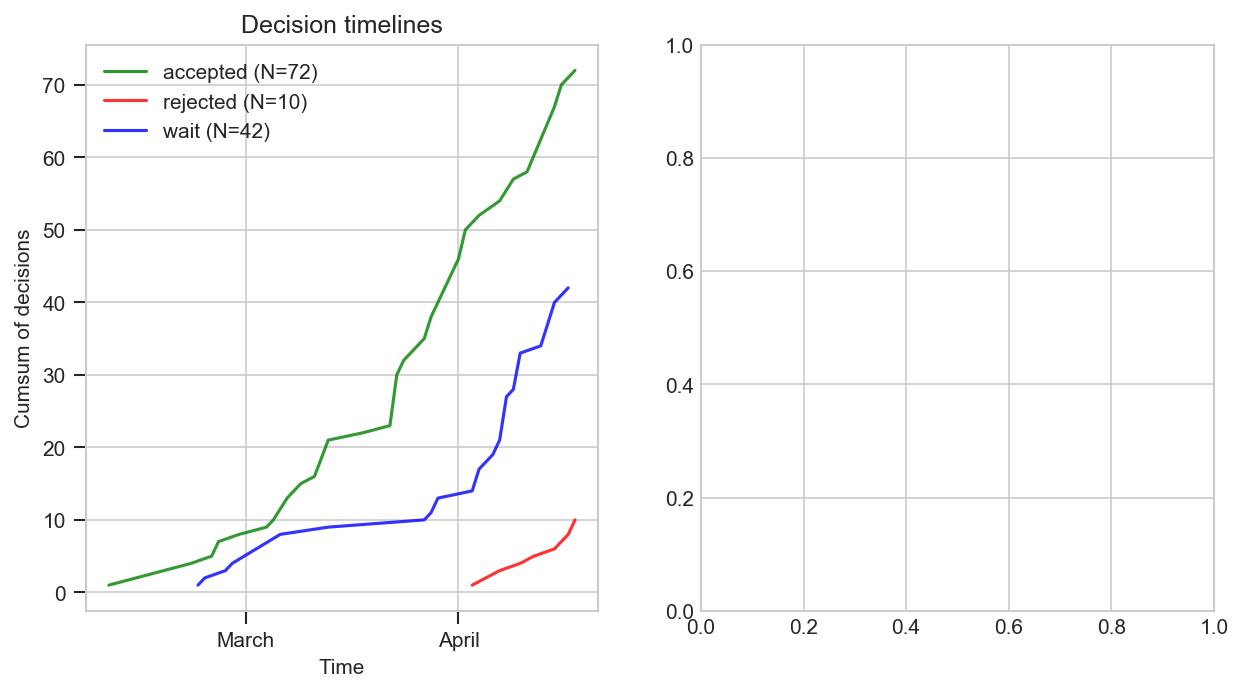

In [19]:
graph_path = '../graphs/'
for program in program_list[-1:]:
    folder_name = program[0].replace('(', '').replace(')', '').replace('  ', ' ').replace(',','').replace(' ', '_').lower()
    program_path = graph_path + folder_name
    if not os.path.exists(program_path):
        os.makedirs(program_path)
    
    print(folder_name)
    for degree in degree_list[1:]:
        degree_name = degree[0].replace('  ', ' ').replace(',','').replace(' ', '_').lower()
        degree_path = program_path + '/' + degree_name
        
        if not os.path.exists(degree_path):
            os.makedirs(degree_path)
        
        for university in uni_list:
            uni_name = university[0].replace('—', '').replace('  ', ' ').replace(' ', '_').lower()
            file_path = degree_path + '/' + uni_name + '_' + folder_name + '_' + degree_name +'.png'
            overall_title = '{}, {}, {}'.format(university[0], program[0], degree[0])
            print(overall_title, '\n')
            try:
                check = plot_all_data(data, uni_query=university[1], program_query=program[1],
                                      degree_query=degree[1], suptitle=overall_title, 
                                      savepath=file_path, 
                                      data_threshold=degree_thres[degree[0]])
            except Exception as e: 
                print(e)
            

In [ ]:
 ('Carnegie Mellon University', 'carnegie | mellon | cmu')

Initial shape (466229, 12)
Shape after cleaning data (2031, 12)
Shape after filtering questions (1973, 12)


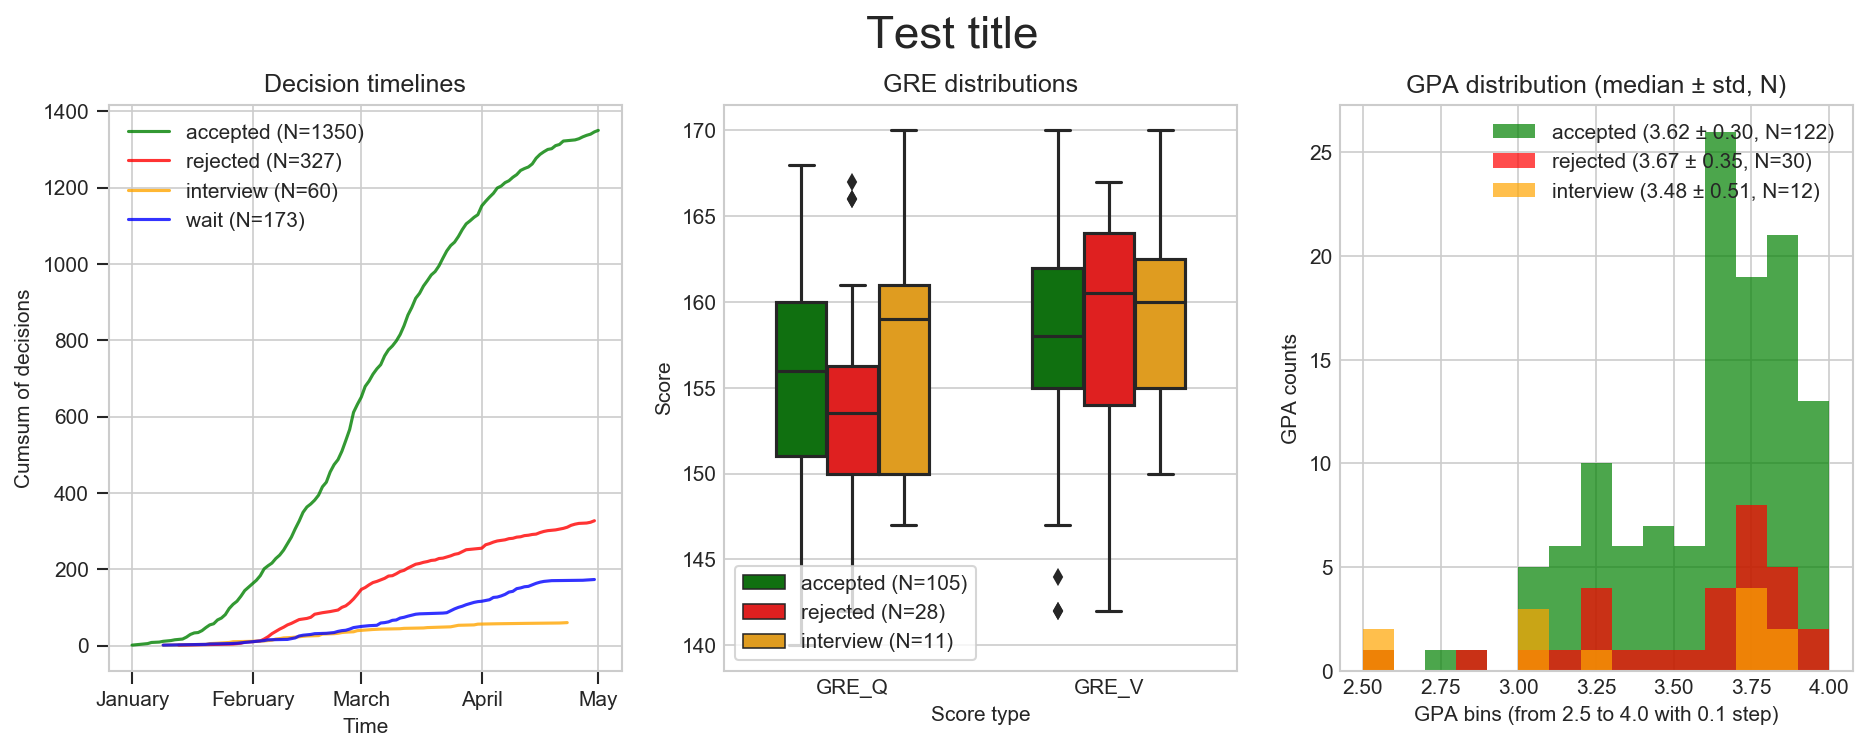

In [13]:
check = plot_all_data(data, uni_query='', 
                      program_query='((?=.*social)(?=.*work))|((?=.*social)(?=.*welf))',
                     degree_query='phd|masters')



In [20]:
check[check.uni == 'University Of Washington']

,uni,program,decision,status,date,comment,actual_date,gpa,gre_v,gre_q,gre_awa,decision_parsed
37984,University Of Washington,"Computer Science (Computer Architecture), PhD ...",Rejected via E-mail on 13 Feb 2013 Undergrad G...,A,2013-02-13,"3.84 GPA, Top Ten Undergrad University, No Res...",2017-02-13,3.84,160,164,5.00,rejected via e-mail
178219,University Of Washington,"Computer Science & Engineering, PhD (F17)",Rejected via E-mail on 4 Feb 2017 Undergrad GP...,I,2017-02-05,Regret to inform you...,2017-02-04,3.79,159,170,4.50,rejected via e-mail
178241,University Of Washington,"Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017,U,2017-02-04,I have 3 years of research experience in machi...,2017-02-03,NaN,NaN,NaN,NaN,rejected via e-mail
178330,University Of Washington,"(Computer Science, PhD (F17)",Rejected via E-mail on 4 Feb 2017,I,2017-02-04,"Well, I feel better knowing you all were rejec...",2017-02-04,NaN,NaN,NaN,NaN,rejected via e-mail
178353,University Of Washington,"Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017 Undergrad GP...,A,2017-02-04,NaN,2017-02-03,3.69,162,168,4.50,rejected via e-mail
178359,University Of Washington,"(Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017 Undergrad GP...,U,2017-02-04,two submitted research papers,2017-02-03,3.70,168,162,3.50,rejected via e-mail
178418,University Of Washington,"Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017 Undergrad GP...,I,2017-02-04,NaN,2017-02-03,NaN,162,164,4.50,rejected via e-mail
178429,University Of Washington,"Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017 Undergrad GP...,I,2017-02-03,Two pubs in top tier AI/ML conferences. Strong...,2017-02-03,3.26,150,170,3.00,rejected via e-mail
178444,University Of Washington,"Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017,U,2017-02-03,NaN,2017-02-03,NaN,NaN,NaN,NaN,rejected via e-mail
178449,University Of Washington,"Computer Science, PhD (F17)",Rejected via E-mail on 3 Feb 2017,NaN,2017-02-03,NaN,2017-02-03,NaN,NaN,NaN,NaN,rejected via e-mail


In [ ]:
def plot_all_data(data, uni_query='(?=.*georgia)(?=.*tech)|gatech', program_query='computer | electrical e | eecs',
                  degree_query = 'phd | master', suptitle='Test title',filter_questions=True, 
                  savepath='graphs/test.png'):

    tst = data[data.actual_date.dt.year < 2018].copy()
    print('Initial shape', tst.shape)
    tst = tst[tst.actual_date.dt.year > 2012]
    tst = tst[(tst.uni.str.lower().str.contains(uni_query)) \
               & (tst.program.str.lower().str.contains(program_query))]
    tst = tst[tst.program.str.lower().str.contains(degree_query)]
    tst.actual_date = tst.actual_date.apply(replace_date)
    tst.loc[tst.gre_q.astype(float) > 170, 'gre_q'] = np.nan
    tst.loc[tst.gre_q.astype(float) < 140, 'gre_q'] = np.nan
    tst.loc[tst.gre_v.astype(float) > 170, 'gre_v'] = np.nan
    tst.loc[tst.gre_v.astype(float) < 140, 'gre_v'] = np.nan

    tst = tst[tst.actual_date.notnull()]
    start_date = pd.to_datetime('2017-1-1')
    end_date = pd.to_datetime('2017-5-1')
    tst = tst[tst.actual_date <= end_date]
    tst = tst[tst.actual_date >= start_date]
    print('Shape after cleaning data', tst.shape)
    
    if tst.shape[0] >= 50:
        if filter_questions:
            tst = tst[~tst.comment.str.lower().str.contains('poster|below').fillna(False)]
            tst = tst[~tst.comment.str.lower().str.contains('anyone|anybody').fillna(False)]
            tst = tst[~tst.comment.str.lower().str.contains('(?=.*who)(?=.*knows)(?=.*\?)').fillna(False)]



            print('Shape after filtering questions', tst.shape)

        fig = plt.figure(figsize=(15,5),dpi=150)
        plot_timelines(tst, fig, subplot_loc=131)
        plot_gre(tst, fig, subplot_loc=132)
        plot_gpa(tst, fig, subplot_loc=133)
        plt.suptitle(suptitle, fontsize=22, y=1.0)
        plt.savefig(savepath, transparent=False)
        #plt.show()
    else:
        print("Data didn't pass 50 element threshold" )
    return tst

In [55]:
tst = data[data.actual_date.dt.year < 2018].copy()
tst = tst[tst.actual_date.dt.year > 2012]
tst = tst[(tst.uni.str.lower().str.contains('')) \
           & (tst.program.str.lower().str.contains('computer'))]
tst = tst[tst.program.str.lower().str.contains('phd')]
tst.actual_date = tst.actual_date.apply(replace_date)
tst.loc[tst.gre_q.astype(float) > 170, 'gre_q'] = np.nan
tst.loc[tst.gre_q.astype(float) < 140, 'gre_q'] = np.nan
tst.loc[tst.gre_v.astype(float) > 170, 'gre_v'] = np.nan
tst.loc[tst.gre_v.astype(float) < 140, 'gre_v'] = np.nan

tst = tst[tst.actual_date.notnull()]
start_date = pd.to_datetime('2017-1-1')
end_date = pd.to_datetime('2017-5-1')
tst = tst[tst.actual_date <= end_date]
tst = tst[tst.actual_date >= start_date]


2016-02-29 00:00:00
2016-02-29 00:00:00
2016-02-29 00:00:00
2016-02-29 00:00:00


(10382, 12)

Initial shape (466229, 12)
Shape after cleaning data (190, 12)
Shape after filtering questions (173, 12)


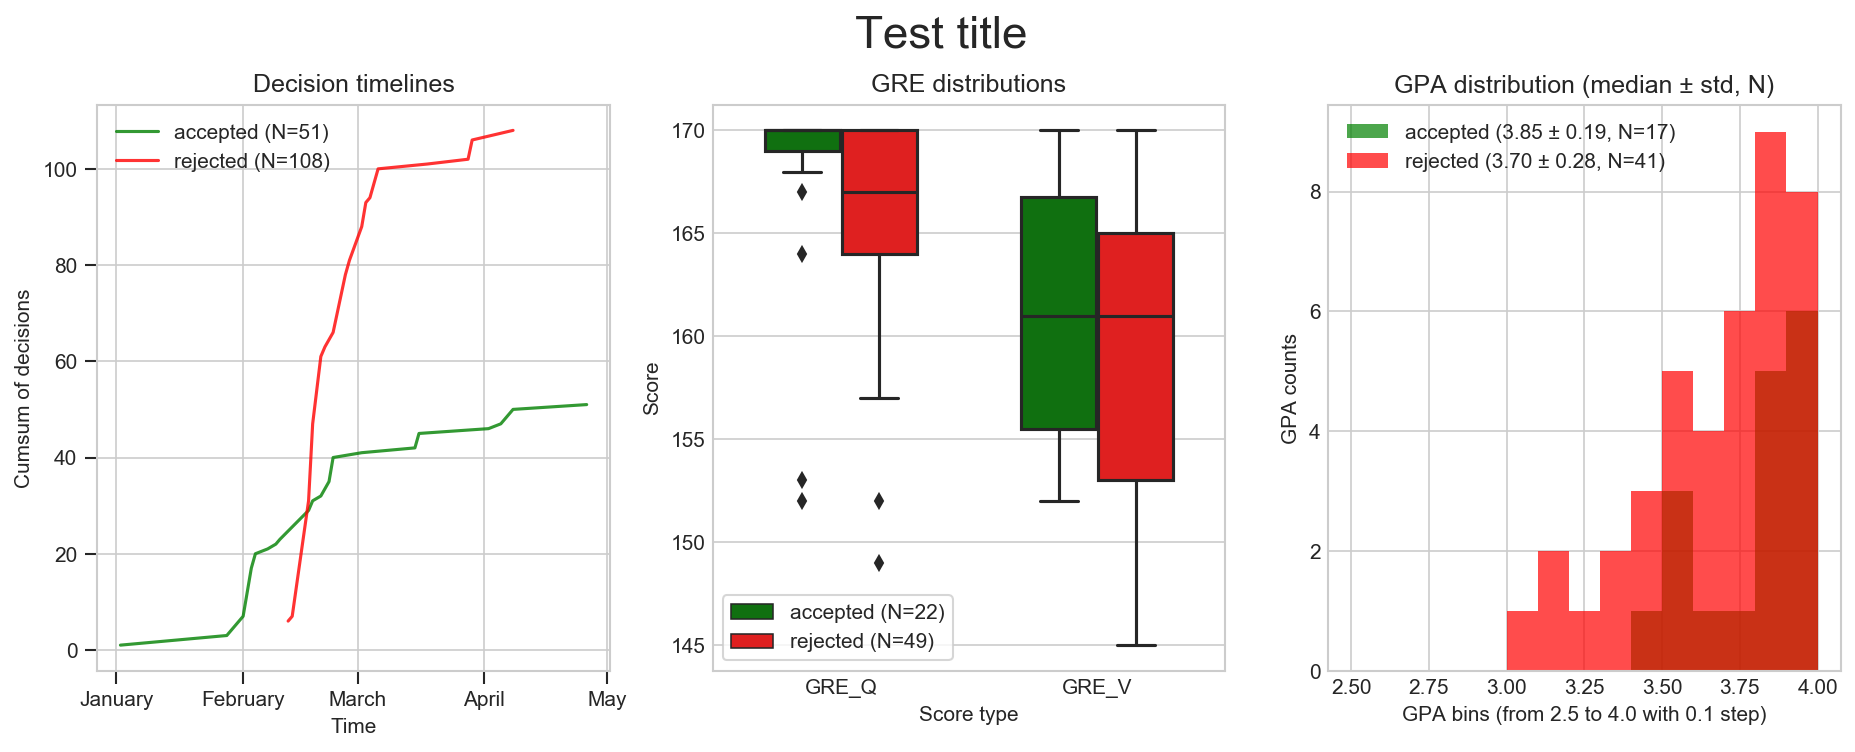

In [862]:
check = plot_all_data(data, uni_query='cmu', program_query='((?=.*machi)(?=.*learn))|((?=.*data)(?=.*sci))|((?=.*arti)(?=.*inte))|((?=.*comp)(?=.*visio))')

In [863]:
check.program.unique()

array(['Computer Science - Machine Learning, PhD (F17)',
       'Neural Computation And Machine Learning, PhD (F17)',
       '(Computer Science - Machine Learning), PhD (F17)',
       'Computer Science Machine Learning (ML), PhD (F17)',
       '(Computer Science - Machine Learning), Masters (F17)',
       'Computer Science - Machine Learning, Masters (F17)',
       'Machine Learning CS Master, Masters (F17)',
       'Computer Science (Machine Learning), Masters (F17)',
       'Machine Learning, Masters (F17)',
       'Computer Science Machine Learning, Masters (F17)',
       'Computer Science, Machine Learning, Masters (F17)',
       'Masters Of Machine Learning, Masters (F17)',
       'Master Of Computational Data Science (MCDS), Masters (F17)',
       'Computational Data Science (MCDS), Masters (F17)',
       'Master Of Science In Computer Vision (MSCV), Masters (F17)',
       'The Master Of Science In Computer Vision (MSCV), Masters (F17)',
       'Computer Vision, Masters (F17)',
 

In [833]:

data[data.uni.str.lower().str.contains('washington').fillna(False)].uni.unique()

array(['"University Of Washington (Seattle)',
       'Washington University In  St. Louis (WUSTL)',
       '"University Of Washington Seattle', '"University Of Washington',
       'Washington University In St. Louis (WashU/WUSTL)',
       'Washington University In St. Louis (WUSL)',
       'Washington University (Wash U, WUSTL)',
       'Washington University In St. Louis (WUSTL)',
       'University Of Washington', 'Washington State U',
       'Washington University In St. Louis (WUSTL) Olin',
       'University Of Washington St. Louis', 'U Of Washington',
       'University Of Washington - Evans School Of Public Affairs',
       'George Washington University',
       'University Of Washington (Evans School)',
       'Olin Washington University In St. Louis',
       'George Washington University (GWU)',
       'University Of Washington Seattle',
       'University Of Washington (Evans Schools Of Public Affairs)',
       'University Of Washington (Foster School Of Business)',
       'W

In [297]:
fin_fig, fin_ax = plt.figure()

fin_fig.add_axes(ax1)

TypeError: 'Figure' object is not iterable

In [45]:
print(tst.uni.unique())
print(tst.program.unique())

['Cornell Tech' 'Cornell (Tech)' 'Cornell' 'Cornell University'
 'Cornell (Ithaca)' 'Cornell Uniersity' 'Cornell Ithaca'
 'Cornell University (Ithaca)' 'Cornell Univer' 'Cornell  University'
 'Cornell Unviversity']
['(Computer Science, Masters (F17)' 'Computer Science, Masters (F17)'
 '(Computer Science, PhD (F17)' 'Computer Science, PhD (F17)'
 'Computer Sciecne, PhD (F17)' '(Computer Science, PhD (S17)'
 '(Computer Science), Masters (F16)' '(Computer Science, Masters (F16)'
 'Computer Science, Masters (F16)' '(Computer Science M.eng, Masters (F16)'
 'Computer Science M.eng, Masters (F16)'
 'Computer Science M.Eng, Masters (F16)' 'Computer Science, PhD (F16)'
 'M.Eng (Computer Science), Masters (F16)'
 'Computer Science, M.Eng., Masters (F16)' '(Computer Science, PhD (F16)'
 '(Computer Science - Machine Learning), PhD (F16)'
 '(Computer Science, Masters (F15)' 'Computer Science, PhD (F15)'
 '(Computer Science ), Masters (F17)' 'Computer Science, Masters (F15)'
 'Computer Science M.Eng

(346, 12)


/home/deaddy/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


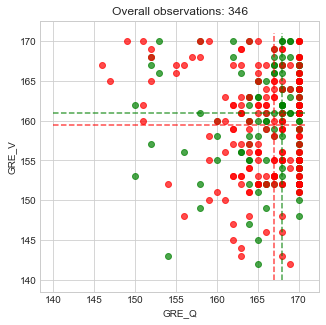

In [12]:
gre_df = tst[~tst[['gre_q', 'gre_v']].isnull().any(axis=1)]
all_size = gre_df.shape[0]
print(gre_df.shape)
keys_list = ['accepted', 'rejected', 'interview', 'wait']
color_dict = dict(zip(keys_list, ['green', 'red', 'orange', 'blue']))

gre_df[['gre_q', 'gre_v']] = gre_df[['gre_q', 'gre_v']].astype(float)

fig, ax = plt.subplots()

all_dfs = []
for item in keys_list[:-2]:
    cur_df = gre_df[gre_df.decision_parsed.str.lower().str.contains(item)]
    plt.scatter(cur_df.gre_q, cur_df.gre_v, color=color_dict[item], alpha=0.7)
    plt.plot([140, 171], [cur_df.gre_v.median()]*2, linestyle='--', color=color_dict[item], alpha=0.7)
    plt.plot([cur_df.gre_q.median()]*2, [140, 171], linestyle='--', color=color_dict[item], alpha=0.7)
plt.xlabel('GRE_Q')
plt.ylabel('GRE_V')
fig.set_size_inches(5, 5)
plt.title('Overall observations: '+ str(all_size))


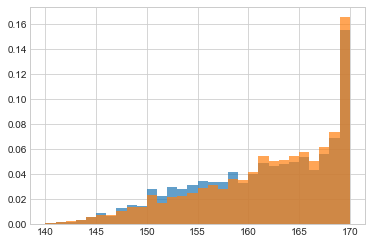

In [387]:
to_plot = data[data.gre_q.notnull()].copy()
to_plot.gre_q = to_plot.gre_q.astype(float)
to_plot = to_plot[to_plot.gre_q <= 170]
to_plot = to_plot[to_plot.gre_q >= 140]

plt.hist(to_plot[to_plot.decision_parsed.str.contains('accepted')].gre_q, bins = 30, normed=True, alpha=0.7)
plt.hist(to_plot[to_plot.decision_parsed.str.contains('rejected')].gre_q, bins = 30, normed=True, alpha=0.7)
pass

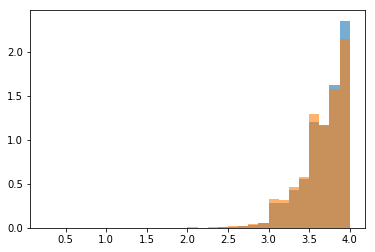

In [21]:
to_plot = data[data.gpa.notnull()].copy()
to_plot.gpa = to_plot.gpa.astype(float)
to_plot = to_plot[to_plot.gpa <= 4]
#to_plot = to_plot[to_plot.gre_q >= 140]

a = plt.hist(to_plot[to_plot.decision_parsed.str.contains('accepted')].gpa, bins = 30, normed=True, alpha=0.6)
plt.hist(to_plot[to_plot.decision_parsed.str.contains('rejected')].gpa, bins = a[1], normed=True, alpha=0.6)
pass

In [50]:
data.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             75,  96,   0,   1, 219, 174, 111, 112, 142,  35],
           dtype='int64', length=499321)

In [467]:
tst = data.loc[7].decision
tst.split('GRE Subject: ')[1][:-1]

'980'

In [69]:
tst.split('on')[0][:-1]

'Interview via E-mail'

In [64]:
''[:-1]

''